# Students:

Name on Kaggle: Group12:
- Mohamed Radwan
- Mithunan Sivagnanam

In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Reading the data

In [236]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [237]:
X_train = pd.read_csv('/content/drive/My Drive/dat300_data/1/X_train.csv')
X_test = pd.read_csv('/content/drive/My Drive/dat300_data/1/X_test.csv')
y_train = pd.read_csv('/content/drive/My Drive/dat300_data/1/y_train.csv')
test_id = X_test.index
X_train.columns = ['Cement', 'Blast', 'Fly Ash', 'Water', 'plast', 'Coarse', 'Fine', 'Age']
y_train.columns = ['Strength']
X_test.columns = ['Cement', 'Blast', 'Fly Ash', 'Water', 'plast', 'Coarse', 'Fine', 'Age']
train = pd.concat([X_train, y_train], axis=1)

# random suffling the data
train.sample(frac=1)

,Cement,Blast,Fly Ash,Water,plast,Coarse,Fine,Age,Strength
466,277.05,0.0,97.39,160.60,11.83,973.9,875.61,28,48.284004
455,285.00,190.0,0.00,163.00,7.60,1031.0,685.00,28,53.579180
213,212.00,0.0,124.78,159.00,7.84,1085.4,799.54,3,19.519066
419,260.90,100.5,78.30,200.60,8.60,864.5,761.50,28,32.401235
346,307.00,0.0,0.00,193.00,0.00,968.0,812.00,365,36.149227
...,...,...,...,...,...,...,...,...,...
277,116.00,173.0,0.00,192.00,0.00,909.8,891.90,28,22.347986
9,167.35,129.9,128.62,175.46,7.79,1006.3,746.60,14,31.812423
359,162.00,207.0,172.00,216.00,10.00,822.0,638.00,28,39.844818
192,150.00,237.0,0.00,174.00,12.00,1069.0,675.00,28,37.431652


## Visualisation of data

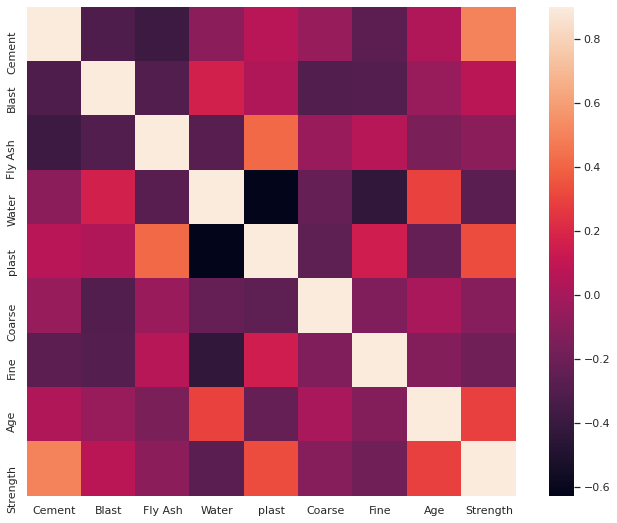

In [238]:
corr_matrix = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corr_matrix, vmax=0.9, square=True)

### Train data scatterplot


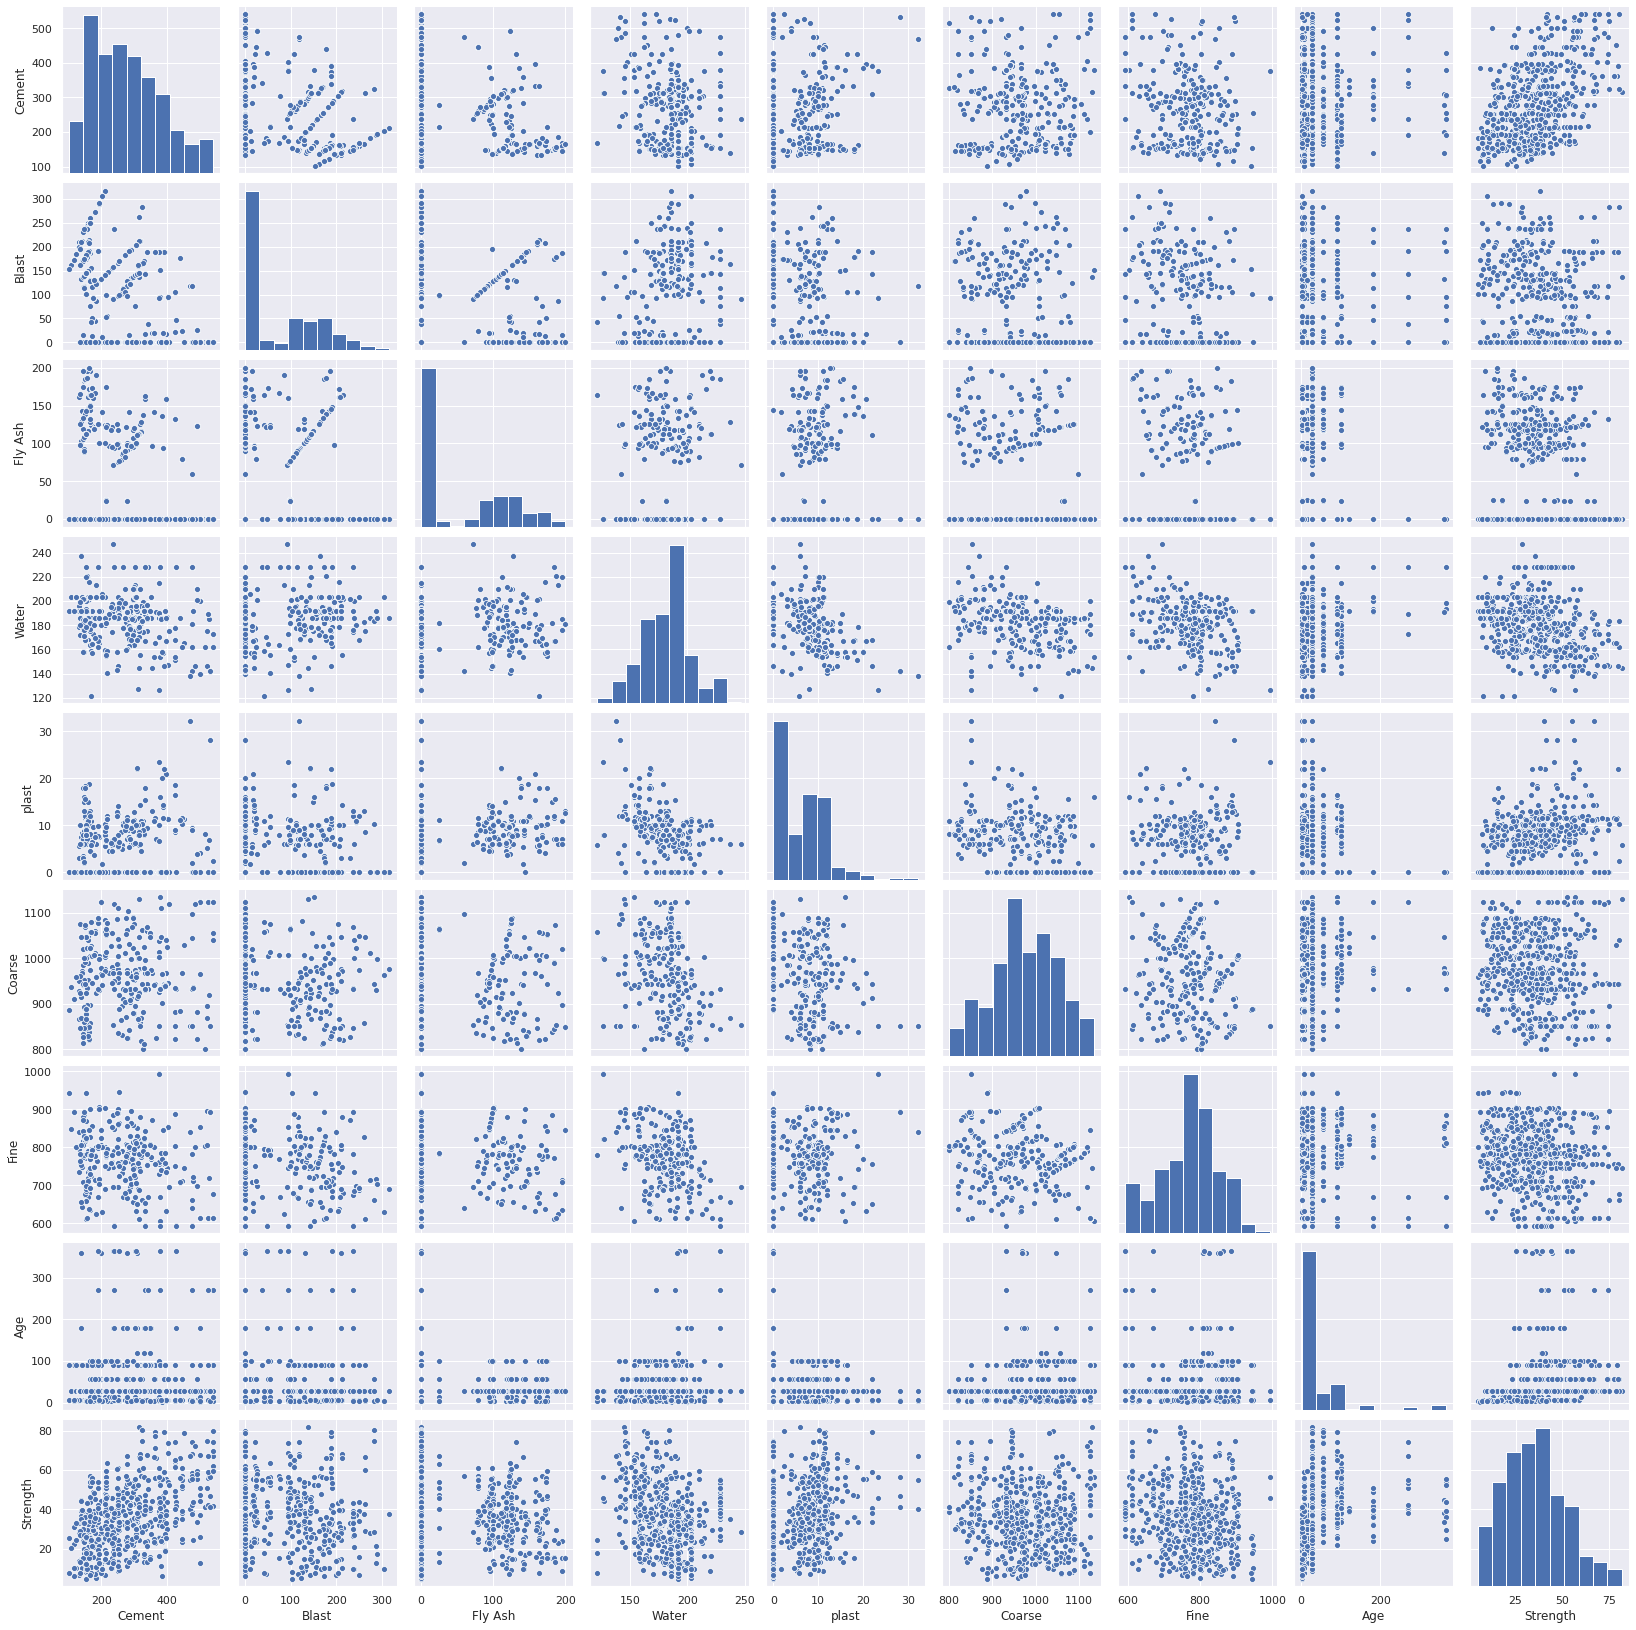

In [239]:
sns.set()
sns.pairplot(train)
plt.show()

### Test data scatterplot

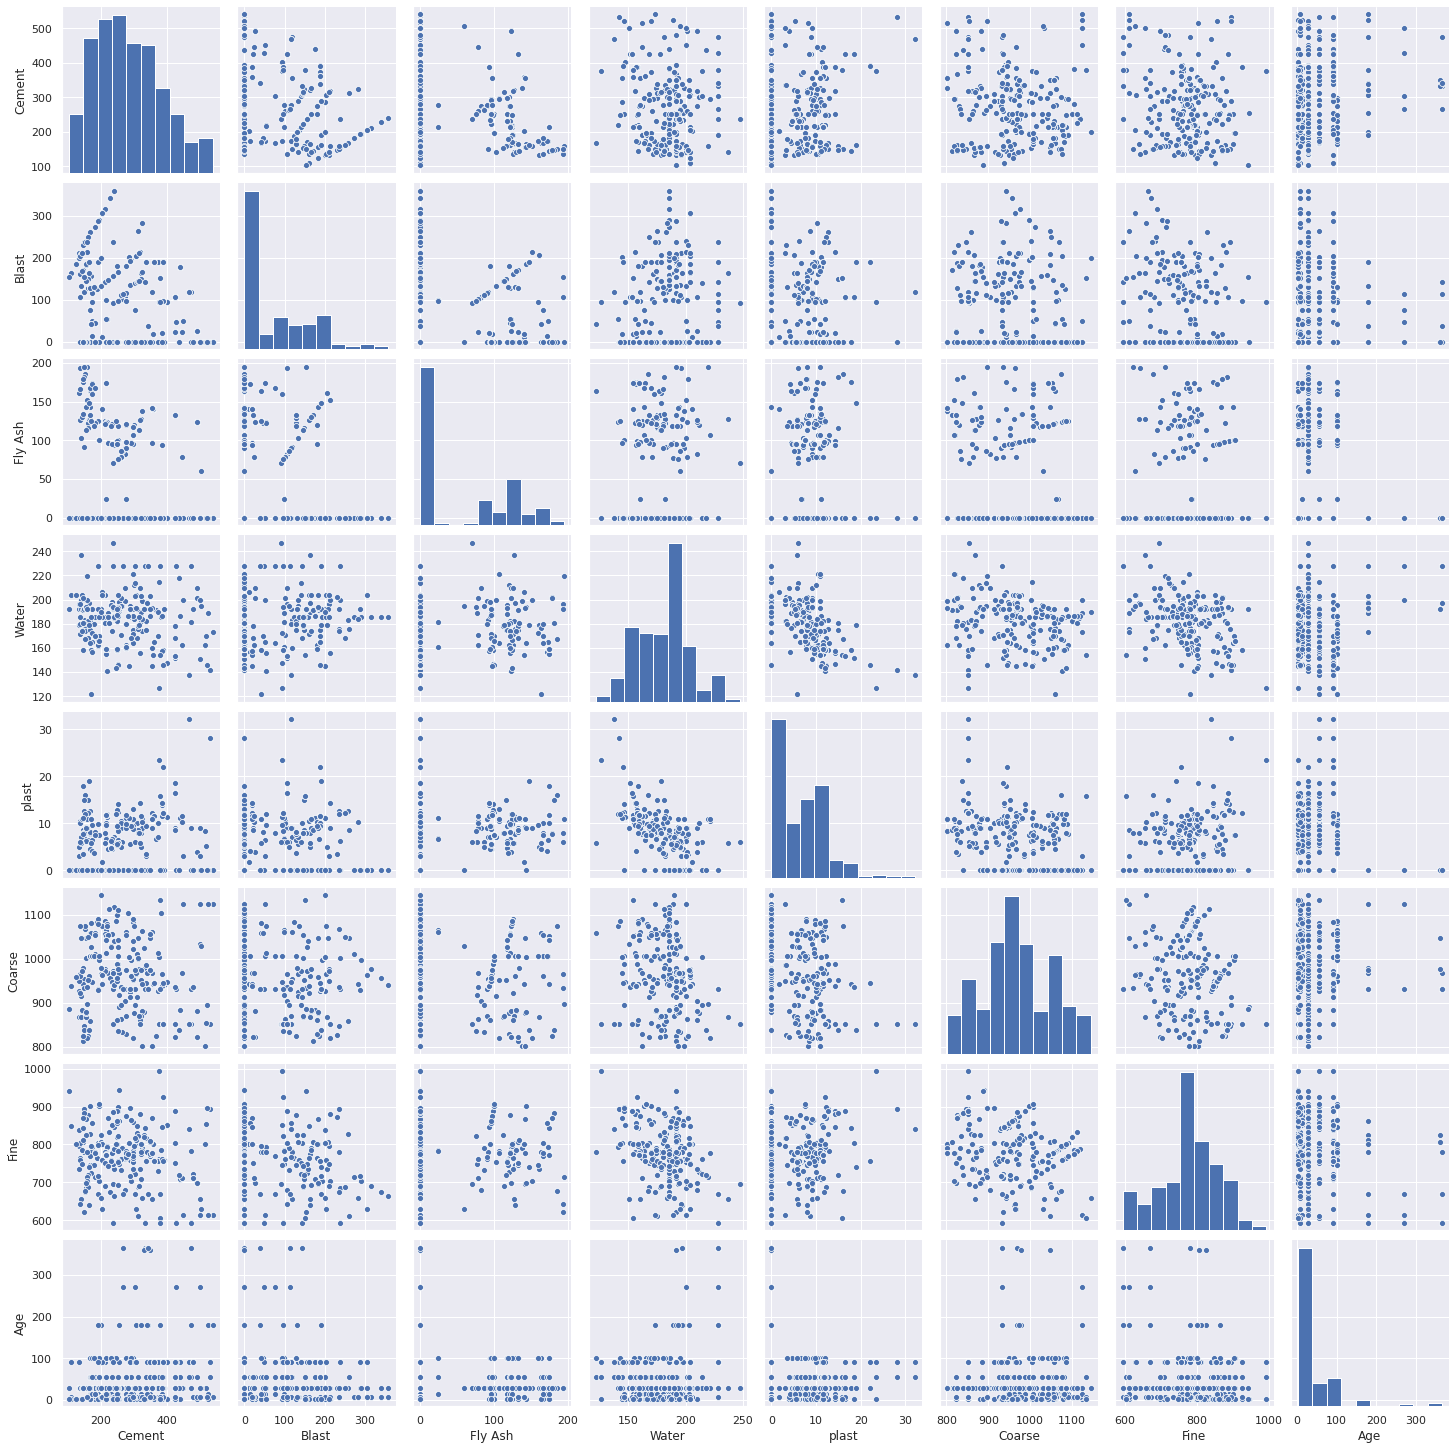

In [6]:
sns.pairplot(X_test)
plt.show()

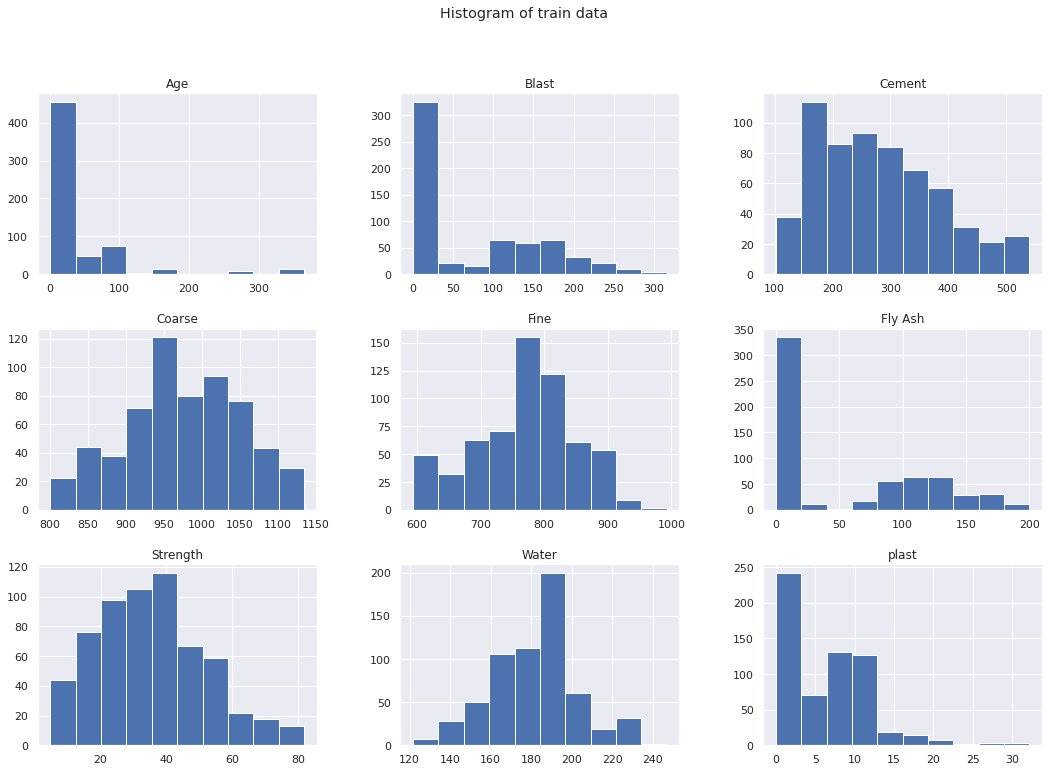

In [240]:
train.hist(figsize=(18, 12))
plt.suptitle('Histogram of train data')
plt.show()

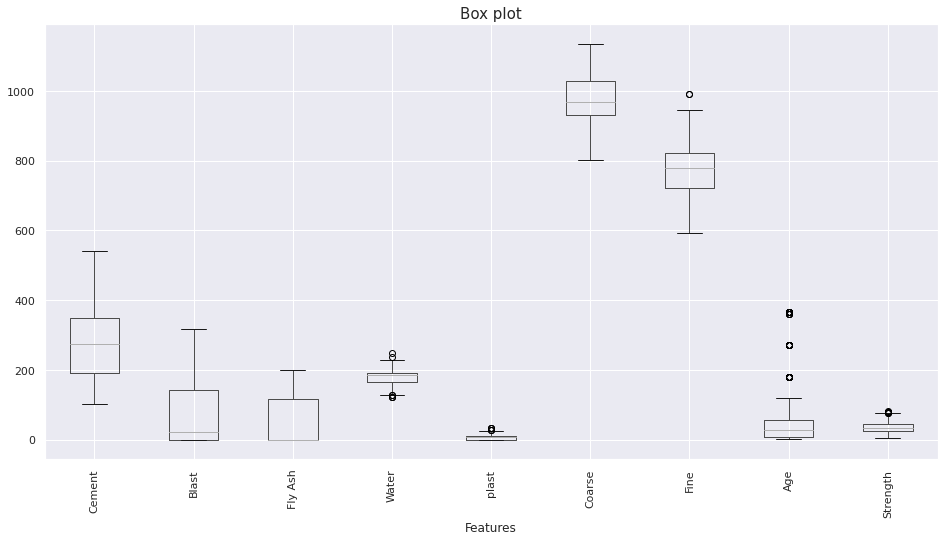

In [9]:
plt.figure(figsize=(16,8))
plt.xlabel('Features')
plt.title('Box plot', fontsize=15)
train.boxplot()
plt.xticks(rotation='vertical')
plt.show()

There are afew outliers but we decided to keep them in the data training as the data already has small number of samples.

- By looking at the scatterplot of test data, one can notice that those outliers exist also in test data, removing them from train data would be losing valuable data. "It would not be inaccuracte to say those are not outliers". (i.e. plast, water, fine columns)

- Several columns in the data are skeewed becuase they contains lots of zeros.


In [241]:
X_train = train.iloc[:, 0:8]
y_train = train.iloc[:, 8]

## Preprocessing
Reducing the skewness of Age column by applying boxcox, a very small value was added to the column to make it strictly positive.

In [242]:
X_train.skew()

Cement     0.531492
Blast      0.707090
Fly Ash    0.527309
Water      0.066598
plast      0.961591
Coarse    -0.062500
Fine      -0.246163
Age        3.244014
dtype: float64

In [243]:
from scipy import stats

X_train.iloc[:,7], _ = stats.boxcox(X_train.iloc[:,7]+0.0000001)
X_test.iloc[:,7], _ = stats.boxcox(X_test.iloc[:,7]+0.000001)

In [244]:
X_train.skew()

Cement     0.531492
Blast      0.707090
Fly Ash    0.527309
Water      0.066598
plast      0.961591
Coarse    -0.062500
Fine      -0.246163
Age       -0.005371
dtype: float64

In [245]:
# Standardization of the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Train
scaler.fit(X_train.astype(np.float64))
X_train_scaled = scaler.transform(X_train.astype(np.float64))
# test
X_test_scaled = scaler.transform(X_test.astype(np.float64))

## Regressions

In [247]:
# split the train data into train and validation data
from sklearn.model_selection import train_test_split
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

### ElasticNet

Using Grid search to estimate best ElasticNet combinations of parameters

In [248]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

elastic = ElasticNet()
para_grids = {
            "alpha" : [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.7, 1, 5 ,10],
            "l1_ratio" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
        }
grid = GridSearchCV(elastic, para_grids, scoring = 'r2',cv=10,n_jobs=-1)
grid.fit(X_train_train, y_train_train)
print (grid.best_score_, grid.best_params_)

0.8020206515748123 {'alpha': 0.0001, 'l1_ratio': 0.1}


In [249]:
best_elastic = ElasticNet(alpha=0.0001, l1_ratio=0.1, max_iter = 1000)
best_elastic.fit(X_train_train, y_train_train)
y_pred =  best_elastic.predict(X_train_val)
elastic_r2 = r2_score(y_train_val, y_pred)
elastic_mse = mean_squared_error(y_train_val, y_pred)
elastic_mae = mean_absolute_error(y_train_val, y_pred)
print('Elastic Net MSE on holdout data: ',elastic_mse)
print('Elastic Net MAE on holdout data: ',elastic_mae)
print('Elastic Net R2 on holdout data: ',elastic_r2)

Elastic Net MSE on holdout data:  57.278919131013346
Elastic Net MAE on holdout data:  5.796336757664767
Elastic Net R2 on holdout data:  0.7783579459273133


### Gradient Boost Regression

In [250]:
from sklearn.ensemble import GradientBoostingRegressor

GB = GradientBoostingRegressor()
para_grids = {
            "n_estimators" : [50, 100, 200, 500, 1000, 1500, 2000],
            "max_depth" : [5, 10],
            "learning_rate" : [0.0001, 0.001, 0.01,  0.1,  1],
        }
grid = GridSearchCV(GB, para_grids, scoring = 'r2',cv=5,n_jobs=-1)
grid.fit(X_train_train, y_train_train.values.ravel())
print (grid.best_score_, grid.best_params_)

0.8938169946740666 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}


In [255]:
best_GB = GradientBoostingRegressor(n_estimators=500, max_depth=5, learning_rate=0.1)
best_GB.fit(X_train_train, y_train_train.values.ravel())
y_pred =  best_GB.predict(X_train_val)
GB_r2 = r2_score(y_train_val, y_pred)
GB_mse = mean_squared_error(y_train_val, y_pred)
GB_mae = mean_absolute_error(y_train_val, y_pred)
print("GB validation R2 on cross holdout data: ", GB_r2)
print("GB validation MSE on cross holdout data: ", GB_mse)
print("GB validation MAE on cross holdout data: ", GB_mae)

GB validation R2 on cross holdout data:  0.7789342237885077
GB validation MSE on cross holdout data:  57.12999173929408
GB validation MAE on cross holdout data:  4.330019111204776


### ANN

In [20]:
import tensorflow as tf

#from tensorflow import keras
from tensorflow.keras import layers, regularizers, initializers, optimizers, models
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, BatchNormalization, InputLayer
from keras.layers import GaussianNoise
print(tf.__version__)


2.3.0


In [21]:
# coefficient of determination (R^2)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [22]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_r_square')>=0.94):
      print('accuracy reached')
      self.model.stop_training = True
accuracy_reached = myCallback()

ANN Architecture:
All hyperparamters choices were taken by brute forcing the MSE and R2 over the CrossValidation. 

- Choices of activations functions, number of neurons, number of layers, optimizer and learning rate as follows
- Weight initializer was taken using HeUniform instead of the default Xaviar initializer
- several regularizers were used (Dropout and kernel regularizers)
- Batch normalization standerdize the input each epoch to speed up the optimzer 

In [216]:
def build_model(lr=0.002, num_neurons=256):
  # seeding the model build, so we can have reproduce results
  np.random.seed(0)
  tf.compat.v1.set_random_seed(0)

  # weights initilizer with seed
  initializer = initializers.HeUniform(44)

  # Regulariser
  regularizer = regularizers.l2(0.01)

  #Adam optimizer
  optimizer = optimizers.Adam(lr=lr)

  # NN artchitecure
  model = models.Sequential([
                             Dense(num_neurons, activation=tf.nn.leaky_relu, 
                                   kernel_initializer=initializer, 
                                   kernel_regularizer=regularizer),
                             Dropout(0.1),
                             BatchNormalization(),
                             Dense(num_neurons/2, activation=tf.nn.sigmoid, 
                                   kernel_initializer=initializer, 
                                   kernel_regularizer=regularizer),
                             Dropout(0.1),
                             BatchNormalization(),
                             Dense(1)])

  model.compile(loss=tf.keras.losses.mse, optimizer=optimizer, 
                metrics=['mae', r_square])

  return model

In [24]:
# This cell is taken from DAT300 lectures
def cross_val_ann(X_train, y_train):
  k = 5
  num_val_samples = len(X_train) // k
  num_epochs = 500
  mse_scores = []
  mae_scores = []
  r2_scores = []

  for i in range(k):
      print('processing fold #', i)
      
      # Prepare the validation data: data from partition # k
      val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
      val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

      # Prepare the training data: data from all other partitions
      partial_train_data = np.concatenate(
          [X_train[:i * num_val_samples],
          X_train[(i + 1) * num_val_samples:]],
          axis=0)
      
      partial_train_targets = np.concatenate(
          [y_train[:i * num_val_samples],
          y_train[(i + 1) * num_val_samples:]],
          axis=0)

      # Build the Keras model (already compiled)
      model = build_model()
      
      # Train the model
      history = model.fit(partial_train_data, partial_train_targets,
                          validation_data=(val_data, val_targets),
                          epochs=num_epochs, batch_size=64, verbose=0)
      
      # Evaluate the model on the validation data
      val_mae = history.history['val_mae']
      val_mse = history.history['val_loss']
      val_r2 = history.history['val_r_square']
      mse_scores.append(val_mse)
      mae_scores.append(val_mae)
      r2_scores.append(val_r2)
  return mse_scores, mae_scores, r2_scores

In [217]:
mse_scores, mae_scores, r2_scores = cross_val_ann(X_train_train, y_train_train)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


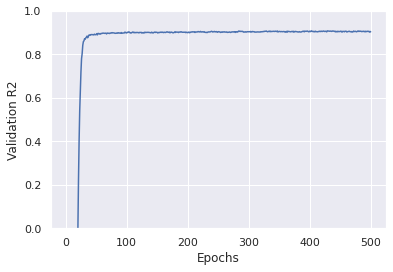

In [251]:
average = [np.mean([x[i] for x in r2_scores]) for i in range(500)]

plt.plot(range(1, len(average) + 1), average)
plt.xlabel('Epochs')
plt.ylabel('Validation R2')
plt.ylim(0, 1)
plt.show()

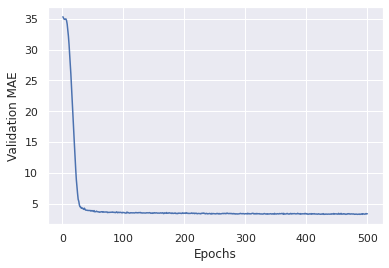

In [252]:
average = [np.mean([x[i] for x in mae_scores]) for i in range(500)]

plt.plot(range(1, len(average) + 1), average)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### Evaluate ANN on train validation data

In [253]:
model = build_model()
model.fit(X_train_train, y_train_train, epochs=400, batch_size=64, verbose=0)
ann_mse, ann_mae, ann_r2 = model.evaluate(X_train_val, y_train_val)

4/4 [==============================] - 0s 2ms/step - loss: 47.2534 - mae: 3.9553 - r_square: 0.8049


### Comparison between regressions on holdout data

Gradientboost and ElasticNet gives almost same scores, while the initial ANN gives R2 of 0.8


In [256]:
print('Elastic R2:', elastic_r2, ', GB R2:', GB_r2, ', ANN R2', ann_r2)
print('Elastic MSE: ', elastic_mse, ', GB MSE: ', GB_mse, ', ANN MSE', ann_mse)
print('Elastic MAE: ', elastic_mae, ', GB MAE: ', GB_mae, ', ANN MAE', ann_mae)

Elastic R2: 0.7783579459273133 , GB R2: 0.7789342237885077 , ANN R2 0.8048856258392334
Elastic MSE:  57.278919131013346 , GB MSE:  57.12999173929408 , ANN MSE 47.25337600708008
Elastic MAE:  5.796336757664767 , GB MAE:  4.330019111204776 , ANN MAE 3.955313205718994


## Tuning the ANN


In [257]:
mse_scores, mae_scores, r2_scores = cross_val_ann(X_train_scaled, y_train)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


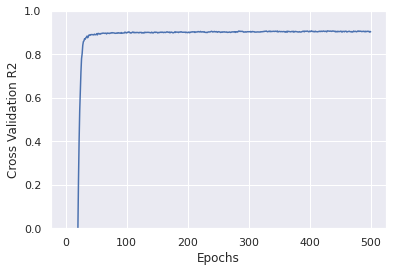

In [262]:
average = [np.mean([x[i] for x in r2_scores]) for i in range(500)]
plt.plot(range(1, len(average) + 1), average)
plt.xlabel('Epochs')
plt.ylabel('Cross Validation R2')
plt.ylim(0, 1)
plt.show()

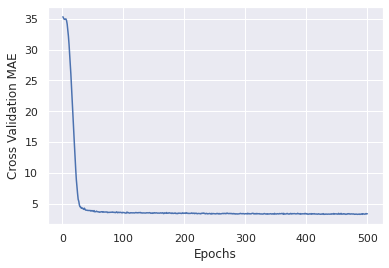

In [261]:
average = [np.mean([x[i] for x in mae_scores]) for i in range(500)]
plt.plot(range(1, len(average) + 1), average)
plt.xlabel('Epochs')
plt.ylabel('Cross Validation MAE')
plt.show()

### Auditing the underfitting/overfitting

400 epochs were the optimal choice as per the choices above

In [258]:
audit_model = build_model()
history = audit_model.fit(X_train_scaled, y_train, epochs=400, batch_size=64, validation_split=0.1, verbose=0)

Max validation R2:  0.9525458216667175
Max training R2:  0.961017906665802
#######################################


<Figure size 432x288 with 0 Axes>

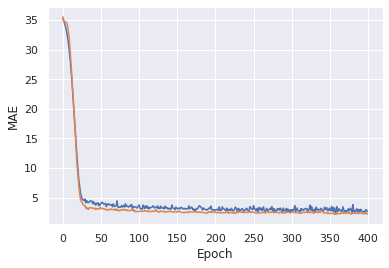

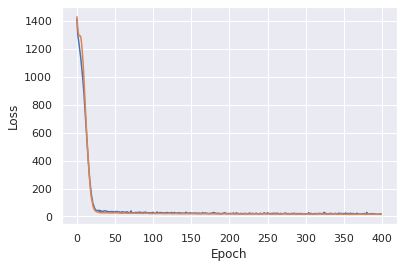

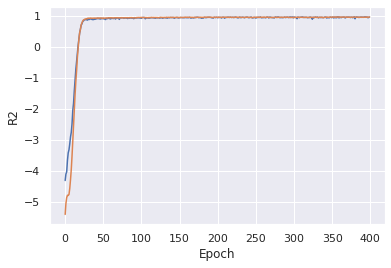

<Figure size 432x288 with 0 Axes>

In [259]:
#-----------------------------------------------------------
# metrics from the audit model
#-----------------------------------------------------------
mae = history.history['mae']
loss = history.history['loss']
rsquare = history.history['r_square']
val_mae = history.history['val_mae']
val_loss = history.history['val_loss']
val_rsquare = history.history['val_r_square']

print('Max validation R2: ', max(val_rsquare))
print('Max training R2: ', max(rsquare))
print('#######################################')
epochs = range(len(mae))

#------------------------------------------------
# training and validation mse per epoch
#------------------------------------------------

plt.plot(epochs, mae)
plt.plot(epochs, val_mae)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.figure()

#------------------------------------------------
# training and validation loss per epoch
#------------------------------------------------

plt.plot(epochs,loss)
plt.plot(epochs, val_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.figure()

#------------------------------------------------
# training and validation R2 per epoch
#------------------------------------------------

plt.plot(epochs, rsquare)
plt.plot(epochs, val_rsquare)
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.figure()

### Ensemble stack of ANN

By stacking several achitectures of ANNs (different number of neurons) and train the meta-regressor ANN on the predictions of test data from the 10 ANN for more stable solution and then using the meta-regressor for prediction.

N.B. This manual implimentation of Stack algorithm is still oversimplified, We couldn't manage to pass our base neural networks objects to scikit-learn Stack nor mlextend stack algorithms.

This gives scores on kaggle around 0.92482. And it takes less than 10 minutes to run on Colab. We anticipated that stack ensambles should provide best results, It improves the results from 0.9 using a single network to 0.92482 but still there is room for development here.

In [263]:
def stack_all_models():
  X_stacks = None
  y_stacks = None

  all_models = []
  num_neurons = np.arange(200, 301, 10)
  for i in num_neurons:
    # train all models on original train data
    model = build_model(num_neurons=i)
    model.fit(X_train_scaled, y_train, shuffle=True, epochs=400, batch_size=64, verbose=0)
    all_models.append(model)

  for model in all_models:
    pred = model.predict(X_test_scaled)
    if X_stacks is None:
      X_stacks = X_test_scaled
      y_stacks = pred
    else:
      y_stacks = np.vstack((y_stacks, pred)) 
      X_stacks = np.vstack((X_stacks, X_test_scaled))  

  meta_model = build_model()
  meta_model.fit(X_stacks, y_stacks, epochs=400, batch_size=64,verbose=0)
  all_models.append(meta_model)

  return all_models

all_models = stack_all_models()
pred = all_models[-1].predict(X_test_scaled)

### Boosting ANN

Make wrapper around the ANN we built, and pass it as estimator to the ScikitLearn Adaboost algorithm with 100 estimators. This gives best results by far, R2 = 0.92884 on Kaggle. This takes a few minutes to run.

In [232]:
from sklearn.ensemble import AdaBoostRegressor
base_ann = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn = build_model, epochs=400, batch_size=64, verbose=0)
boost_ann = AdaBoostRegressor(base_estimator=base_ann, n_estimators=100, learning_rate=0.8)
boost_ann.fit(X_train_scaled, y_train.values.ravel()) 
pred = boost_ann.predict(X_test_scaled)

In [265]:
# Save results
submission = pd.DataFrame({'Id':test_id, 'Predicted':pred.reshape(412,).astype(float)})
submission.to_csv("submission171.csv",index=False)

from google.colab import files
files.download("submission171.csv")
print("Done")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Done


## References:

NMBU DAT300 materials

Laurence Moroney, DeepLearning.AI TensorFlow materials, Coursera, 2020.

https://stackoverflow.com/questions/39063676/how-to-boost-a-keras-based-neural-network-using-adaboost

Martin T. Hagan, Howard B. Demuth, Mark Hudson Beale, Orlando De Jesús, Neural Network Design, https://hagan.okstate.edu/NNDesign.pdf

https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/

https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network

https://keras.io/api/optimizers/

https://blog.statsbot.co/ensemble-learning-d1dcd548e936